In [ ]:
!pip install mne
!pip install autoreject
from google.colab import files
uploaded = files.upload()

import os
edf_file = list(uploaded.keys())[0]3
print(f"Uploaded: {edf_file}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 26.5 MB/s eta 0:00:00


Saving 002 (1).edf to 002 (1).edf
Uploaded: 002 (1).edf


In [ ]:
import mne

# Load .edf data
raw = mne.io.read_raw_edf(edf_file, preload=True)

# Select only EEG channels used
eeg_channels = ['AF3', 'AF4', 'T7', 'T8', 'Pz']
raw.pick_channels(eeg_channels)

Extracting EDF parameters from /content/002 (1).edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22911  =      0.000 ...   178.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<RawEDF | 002 (1).edf, 5 x 22912 (179.0 s), ~904 KiB, data loaded>

In [ ]:
custom_montage = mne.channels.make_dig_montage(
    ch_pos={
        'AF3': [-0.03,  0.08,  0.06],
        'AF4': [ 0.03,  0.08,  0.06],
        'T7':  [-0.08,  0.00,  0.03],
        'T8':  [ 0.08,  0.00,  0.03],
        'Pz':  [ 0.00, -0.05,  0.07]
    },
    coord_frame='head'
)
raw.set_montage(custom_montage)

<RawEDF | 002 (1).edf, 5 x 22912 (179.0 s), ~908 KiB, data loaded>

In [ ]:
raw_filtered = raw.copy().filter(1., 50., fir_design='firwin')
raw_filtered.notch_filter(freqs=[50, 60])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


<RawEDF | 002 (1).edf, 5 x 22912 (179.0 s), ~907 KiB, data loaded>

In [ ]:
from autoreject import AutoReject

# Split data into 1-second epochs
epochs = mne.make_fixed_length_epochs(raw_filtered, duration=1.0, preload=True)

# Fit Autoreject
ar = AutoReject()
epochs_clean = ar.fit_transform(epochs)

print(f"Original epochs: {len(epochs)}")
print(f"Cleaned epochs: {len(epochs_clean)}")

Not setting metadata
179 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 179 events and 128 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/5 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/179 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/179 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/179 [00:00<?,       ?it/s]

/usr/local/lib/python3.11/dist-packages/mne/bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/179 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.90 and n_interpolate=1


  0%|          | Repairing epochs : 0/179 [00:00<?,       ?it/s]

Dropped 2 epochs: 22, 90
Original epochs: 179
Cleaned epochs: 177


In [ ]:
# Concatenate epochs into continuous signal
data = epochs_clean.get_data().reshape(len(eeg_channels), -1)
sfreq = raw.info['sfreq']
info = mne.create_info(ch_names=eeg_channels, sfreq=sfreq, ch_types='eeg')
raw_clean = mne.io.RawArray(data, info)
raw_clean.set_montage(custom_montage)

Creating RawArray with float64 data, n_channels=5, n_times=22656
    Range : 0 ... 22655 =      0.000 ...   176.992 secs
Ready.


<RawArray | 5 x 22656 (177.0 s), ~897 KiB, data loaded>

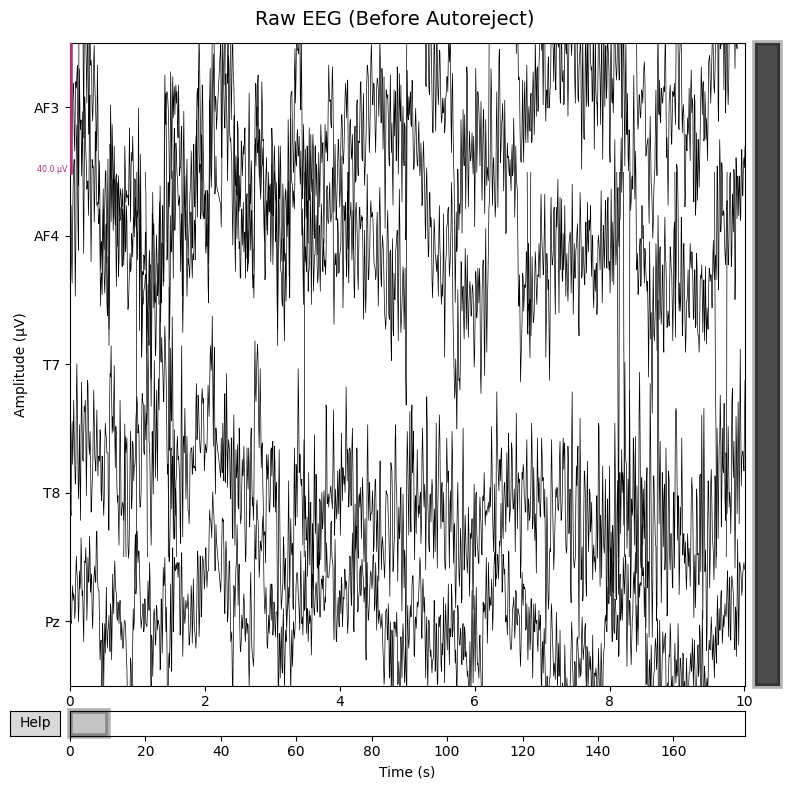

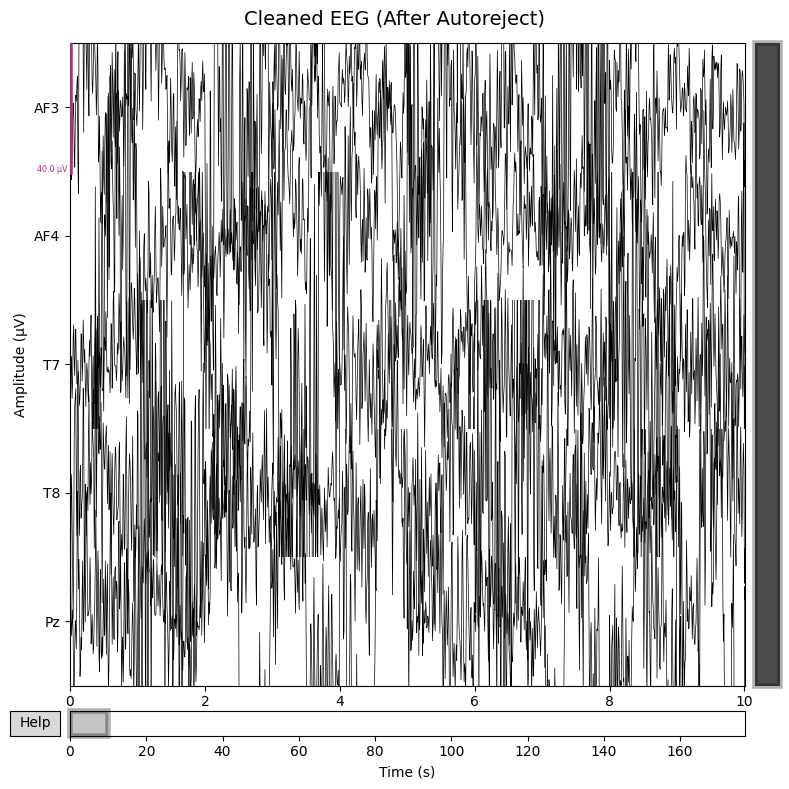

In [ ]:
# Plot EEG Before Autoreject
fig_before = raw.plot(n_channels=5, title="EEG Traces Before Autoreject", show=False)
fig_before.suptitle("Raw EEG (Before Autoreject)", fontsize=14)
fig_before.axes[0].set_ylabel("Amplitude (µV)")
fig_before.axes[0].set_xlabel("Time (s)")
fig_before.tight_layout()
fig_before.savefig("trace_before_autoreject.png")
fig_before.savefig("trace_before_autoreject.pdf")

# Plot EEG After Autoreject
fig_after = raw_clean.plot(n_channels=5, title="EEG Traces After Autoreject", show=False)
fig_after.suptitle("Cleaned EEG (After Autoreject)", fontsize=14)
fig_after.axes[0].set_ylabel("Amplitude (µV)")
fig_after.axes[0].set_xlabel("Time (s)")
fig_after.tight_layout()
fig_after.savefig("trace_after_autoreject.png")
fig_after.savefig("trace_after_autoreject.pdf")

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


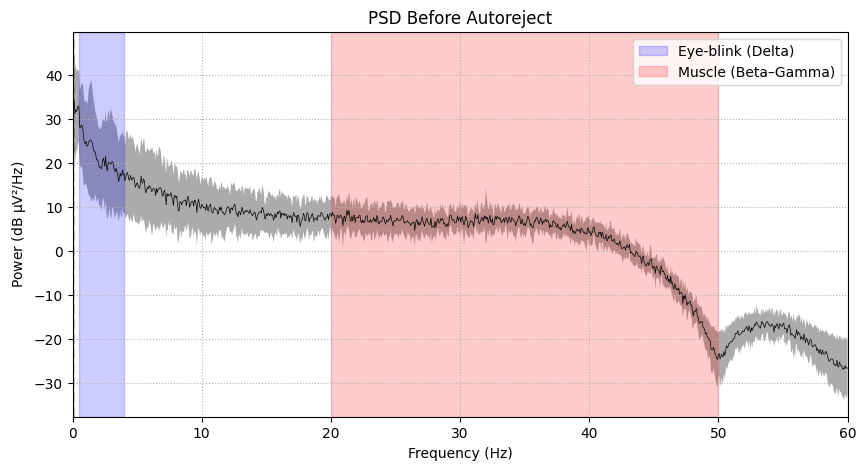

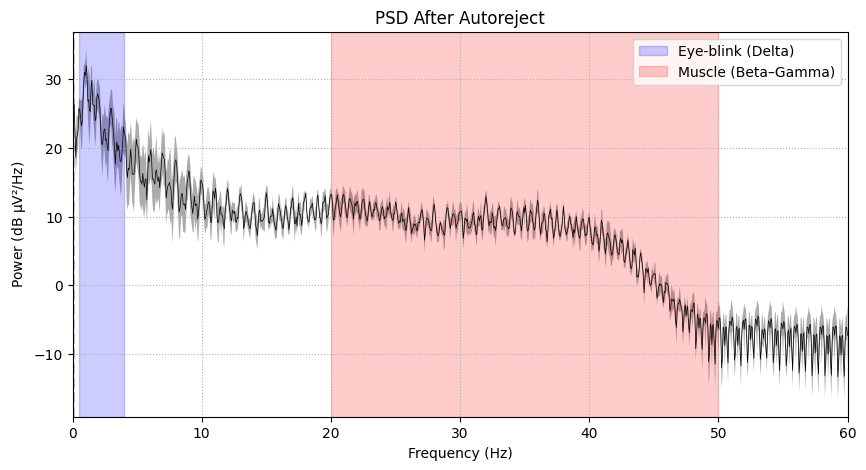

In [ ]:
import matplotlib.pyplot as plt

def plot_psd_with_bands(raw_obj, title, prefix):
    fig, ax = plt.subplots(figsize=(10, 5))
    raw_obj.plot_psd(fmax=60, ax=ax, average=True, show=False)
    ax.axvspan(0.5, 4, color='blue', alpha=0.2, label='Eye-blink (Delta)')
    ax.axvspan(20, 50, color='red', alpha=0.2, label='Muscle (Beta–Gamma)')
    ax.set_title(title)
    ax.legend()
    fig.savefig(f"{prefix}.png")
    fig.savefig(f"{prefix}.pdf")

# PSD Before
plot_psd_with_bands(raw, "PSD Before Autoreject", "psd_before_autoreject")

# PSD After
plot_psd_with_bands(raw_clean, "PSD After Autoreject", "psd_after_autoreject")

In [ ]:
!zip -r task2_autoreject_figures.zip trace_before_autoreject.* trace_after_autoreject.* psd_before_autoreject.* psd_after_autoreject.*
from google.colab import files
files.download("task2_autoreject_figures.zip")

  adding: trace_before_autoreject.pdf (deflated 11%)
  adding: trace_before_autoreject.png (deflated 4%)
  adding: trace_after_autoreject.pdf (deflated 7%)
  adding: trace_after_autoreject.png (deflated 4%)
  adding: psd_before_autoreject.pdf (deflated 14%)
  adding: psd_before_autoreject.png (deflated 6%)
  adding: psd_after_autoreject.pdf (deflated 14%)
  adding: psd_after_autoreject.png (deflated 5%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>